# Code for Salmon detection

In [1]:
# Cleaning the dataset

import os
import json
import numpy as np

root = "/Users/magnuswiik/prosjektoppgave_data/transfer_300774_files_a22bc256/Ide4_OpenClosedTransport/GP020101_rotated-annoterte-test"

annots = list(sorted(os.listdir(os.path.join(root, "Boxes"))))
imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))

numbers = []

for annot in annots:
    number = annot[:-5]
    numbers.append(number)
    
    if annot[-4:] != "json":
        path = root + "/Boxes/" + annot
        print("Not a json file", path)
        os.remove(root + "/Boxes/" + annot)
        
    annots_path = os.path.join(root, "Boxes", annot)
    shapes = json.load(open(annots_path))['shapes']
    
    if len(shapes) == 0:
        path = root + "/Boxes/" + annot
        os.remove(root + "/Boxes/" + annot)


# Removes redundant images, so the number of jsons equal the number of imgs

for file in imgs:
    name = file[:-4]
    if name not in numbers:
        path = root + "/Images/" + file
        os.remove(root + "/Images/" + file)

# SalmonData set uses only the label '1' to signalize a Salmon. This is for Salmon detection task

In [24]:
import os
import json
import torch

from torchvision.io import read_image
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import numpy as np


class SalmonDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))
        self.annots = list(sorted(os.listdir(os.path.join(root, "Boxes"))))
    
    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        annots_path = os.path.join(self.root, "Boxes", self.annots[idx])
        
        img = read_image(img_path)
        if "DS" not in annots_path:
            try:
                shapes = json.load(open(annots_path))['shapes']
            except:
                print("Cannot open json file...")
            
        boxes = [shape['points'] for shape in shapes]
        boxes_flattened = []
        for box in boxes:
            box = np.array(box).flatten().tolist()
            boxes_flattened.append(box)
        
        boxes_flattened = torch.tensor(boxes_flattened, dtype=torch.float)
        

        # Number of boxes in image
        num_objs = len(boxes_flattened)

        # there is only one class -> Salmon = 1
        labels = torch.ones((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)
        img = img.float() / 255.0
        

        target = {}
        target["boxes"] = boxes_flattened
        target["labels"] = labels
        target["image_id"] = idx
        target["area"] = (boxes_flattened[:,2]-boxes_flattened[:,0])*(boxes_flattened[:,3]-boxes_flattened[:,1])
        target["iscrowd"] = torch.zeros((num_objs,), dtype=torch.int64)

        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        if target["boxes"].numel() == 0:
            print("No boxes :(")

        return img, target

    def __len__(self):
        return len(self.imgs)

# SalmonIndividualsDataset uses group_id as label to facilitate the making of a individual reidentification dataset

In [9]:
import os
import json
import torch

from torchvision.io import read_image
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import numpy as np


class SalmonIndividualsDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))
        self.annots = list(sorted(os.listdir(os.path.join(root, "Boxes"))))
    
    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        annots_path = os.path.join(self.root, "Boxes", self.annots[idx])
        
        img = read_image(img_path)
        if "DS" not in annots_path:
            try:
                shapes = json.load(open(annots_path))['shapes']
            except:
                print("Cannot open json file...")
            
        
        boxes = []
        labels = []
        
        for shape in shapes:
            if shape['group_id'] is not None:
                labels.append(shape['group_id'])
                boxes.append(shape['points'])
                
        
        boxes_flattened = []
        for box in boxes:
            box = np.array(box).flatten().tolist()
            boxes_flattened.append(box)
        
        boxes_flattened = torch.tensor(boxes_flattened, dtype=torch.float)
        
        if boxes_flattened.ndim == 1:
            # Remove file that have no fish annotated
            os.remove(img_path)
            os.remove(annots_path)
        

        # Number of boxes in image
        num_objs = len(boxes_flattened)

        # there is only one class -> Salmon = 1
        labels = torch.tensor(labels, dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)
        img = img.float() / 255.0

        target = {}
        target["boxes"] = boxes_flattened
        target["labels"] = labels
        target["image_id"] = idx
        target["area"] = (boxes_flattened[:,2]-boxes_flattened[:,0])*(boxes_flattened[:,3]-boxes_flattened[:,1])
        target["iscrowd"] = torch.zeros((num_objs,), dtype=torch.int64)

        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        if target["boxes"].numel() == 0:
            print("No boxes :(")

        return img, target

    def __len__(self):
        return len(self.imgs)

In [21]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights

def get_detection_model(num_classes, weights=FasterRCNN_ResNet50_FPN_Weights):
    # load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [5]:
"""os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")"""


'os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")\nos.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")\nos.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")\nos.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")\nos.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")'

# Assign indices to training, validation and test that takes datasources into consideration

In [22]:
# Split datasources equally into training, validation and test sets

import torch
import random

# Random seeds for reproducibility
g = torch.manual_seed(0)
random.seed(0)

data_path = "/Users/magnuswiik/prosjektoppgave_data/Masteroppgave_data/Christian_Annotert_Deteksjonssett/"

imgs = SalmonDataset(data_path).imgs

sourceindices = {'out1':0,
           'trigger21_out2':0,
           'smoltrecording_out2':0,
           'BIORACER':0,
           'Hero4':0,
           'OpenTransport':0}

for img in imgs:
    if 'out1' in img:
        sourceindices['out1'] = imgs.index(img)
    elif 'trigger21_out2'in img:
        sourceindices['trigger21_out2'] = imgs.index(img)
    elif 'smoltrecording_out2' in img:
        sourceindices['smoltrecording_out2'] = imgs.index(img)
    elif 'BIORACER' in img:
        sourceindices['BIORACER'] = imgs.index(img)
    elif 'Hero4' in img:
        sourceindices['Hero4'] = imgs.index(img)
    elif 'OpenTransport' in img:
        sourceindices['OpenTransport'] = imgs.index(img)
    else:
        print('A file is not counted!')

# Generate indices for each datasource      
sourceindices['out1'] = list(range(0,sourceindices['out1']))
sourceindices['trigger21_out2'] = list(range(sourceindices['out1'][-1], sourceindices['trigger21_out2']))
sourceindices['smoltrecording_out2'] = list(range(sourceindices['trigger21_out2'][-1], sourceindices['smoltrecording_out2']))
sourceindices['BIORACER'] = list(range(sourceindices['smoltrecording_out2'][-1], sourceindices['BIORACER']))
sourceindices['Hero4'] = list(range(sourceindices['BIORACER'][-1], sourceindices['Hero4']))
sourceindices['OpenTransport'] = list(range(sourceindices['Hero4'][-1], sourceindices['OpenTransport']))

indices_test = []
indices_validation = []
indices_training = []

# Distribute indices to each set by random sampling in a non-overlapping way
for source in sourceindices:
    indices_test += random.sample(sourceindices[source], int(len(sourceindices[source])*0.2))
    sourceindices[source] = [idx for idx in sourceindices[source] if idx not in indices_test]
    indices_validation += random.sample(sourceindices[source], int(len(sourceindices[source])*0.2))
    sourceindices[source] = [idx for idx in sourceindices[source] if idx not in indices_validation]
    indices_training += sourceindices[source]
    
# Shuffle once more to eradicate any sytematic trend in each set
random.shuffle(indices_test)
random.shuffle(indices_validation)
random.shuffle(indices_training)

# use our dataset and defined transformations
dataset = SalmonDataset(data_path)
dataset_validation = SalmonDataset(data_path)
dataset_test = SalmonDataset(data_path)

# split the dataset in train and test set
dataset_training = torch.utils.data.Subset(dataset, indices_training) # 80% for training and validation
dataset_validation = torch.utils.data.Subset(dataset_validation, indices_validation)
dataset_test = torch.utils.data.Subset(dataset_test, indices_test) # 20% for testing



# Training the Detection model

In [25]:
# Train and evaluate the model

from engine import train_one_epoch, evaluate
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2


# define training and validation data loaders
data_loader_training = torch.utils.data.DataLoader(
    dataset_training,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=utils.collate_fn,
    generator=g
)

# define training and validation data loaders
data_loader_validation = torch.utils.data.DataLoader(
    dataset_validation,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    collate_fn=utils.collate_fn,
    generator=g
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=utils.collate_fn,
    generator=g
)

# get the model using our helper function
model = get_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs
num_epochs = 5

metric_loggers = []

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    metric_logger = train_one_epoch(model, optimizer, data_loader_training, device, epoch, print_freq=10)
    metric_loggers.append(metric_logger)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    
evaluate(model, data_loader_validation, device=device)

# TESTSET EVALUATION
#evaluate(model, data_loader_test, device=device)

PATH = "/Users/magnuswiik/Documents/NTNU/5.klasse/prosjektoppgave/FishID/models"

torch.save(model.state_dict(), PATH + "model_weights1_Masteroppgave.pt")

print("That's it!")

/Users/magnuswiik/miniconda3/envs/fisketrening/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: [0]  [  0/551]  eta: 0:57:13  lr: 0.000014  loss: 1.0098 (1.0098)  loss_classifier: 0.7708 (0.7708)  loss_box_reg: 0.2051 (0.2051)  loss_objectness: 0.0231 (0.0231)  loss_rpn_box_reg: 0.0108 (0.0108)  time: 6.2321  data: 0.1410
Epoch: [0]  [ 10/551]  eta: 0:50:43  lr: 0.000105  loss: 1.0990 (1.0992)  loss_classifier: 0.7081 (0.6749)  loss_box_reg: 0.3003 (0.2831)  loss_objectness: 0.0806 (0.1159)  loss_rpn_box_reg: 0.0227 (0.0253)  time: 5.6256  data: 0.1142
Epoch: [0]  [ 20/551]  eta: 0:52:28  lr: 0.000196  loss: 0.9473 (0.9632)  loss_classifier: 0.4412 (0.5228)  loss_box_reg: 0.3093 (0.3191)  loss_objectness: 0.0676 (0.0961)  loss_rpn_box_reg: 0.0227 (0.0252)  time: 5.9150  data: 0.1144
Epoch: [0]  [ 30/551]  eta: 0:50:46  lr: 0.000287  loss: 0.7045 (0.8687)  loss_classifier: 0.3021 (0.4465)  loss_box_reg: 0.3359 (0.3255)  loss_objectness: 0.0305 (0.0744)  loss_rpn_box_reg: 0.0181 (0.0222)  time: 5.9702  data: 0.1175
Epoch: [0]  [ 40/551]  eta: 0:49:18  lr: 0.000377  loss: 0.5

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [  0/272]  eta: 0:04:08  model_time: 0.8444 (0.8444)  evaluator_time: 0.0042 (0.0042)  time: 0.9126  data: 0.0639
Test:  [100/272]  eta: 0:02:24  model_time: 0.8417 (0.7874)  evaluator_time: 0.0016 (0.0017)  time: 0.8723  data: 0.0552
Test:  [200/272]  eta: 0:01:01  model_time: 0.8389 (0.7934)  evaluator_time: 0.0016 (0.0017)  time: 0.8734  data: 0.0566
Test:  [271/272]  eta: 0:00:00  model_time: 0.8337 (0.7918)  evaluator_time: 0.0015 (0.0017)  time: 0.8695  data: 0.0576
Test: Total time: 0:03:50 (0.8469 s / it)
Averaged stats: model_time: 0.8337 (0.7918)  evaluator_time: 0.0015 (0.0017)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.813
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.934
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.914
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small 

# Plot annotations

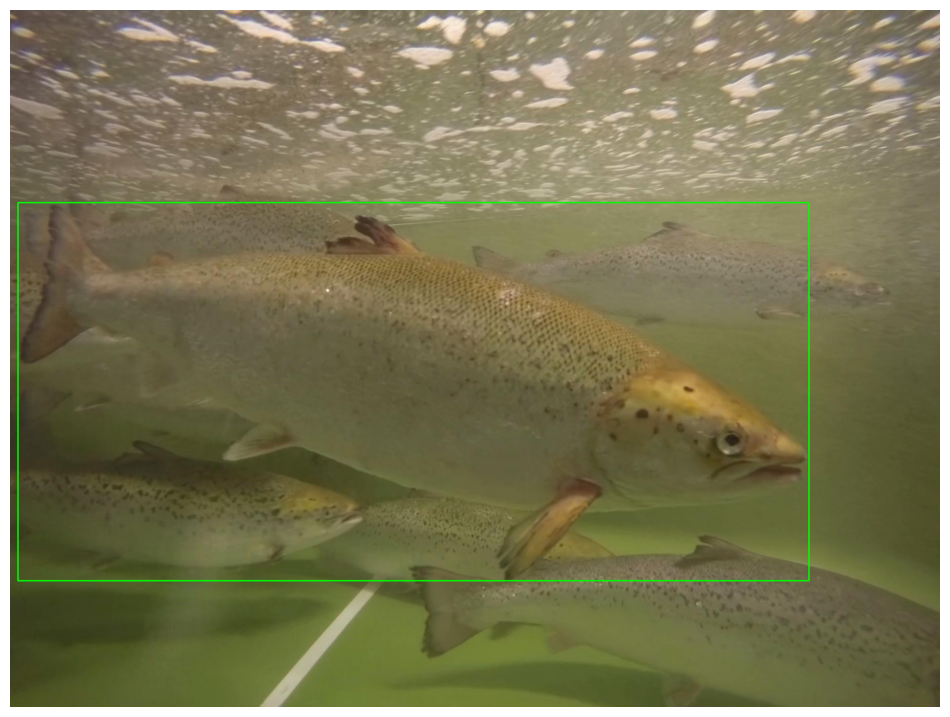

In [20]:
# Inference from trained model
import matplotlib.pyplot as plt
import cv2
import os, json

root = "/Users/magnuswiik/prosjektoppgave_data/Masteroppgave_data/Helfisk_Deteksjonssett/"

annots = list(sorted(os.listdir(os.path.join(root, "Boxes"))))
imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))

index = 70

image_path = os.path.join(root, "Images", imgs[index])
boxes_path = os.path.join(root, "Boxes", annots[index])

image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

boxes = []

with open(boxes_path,'r') as file:
    content = json.load(file)
    shapes = content['shapes']
    for shape in shapes:
        boxes.append(shape['points'])

# Draw bounding boxes on the image
for box in boxes:
    min, max = box
    cv2.rectangle(image, (int(min[0]), int(min[1])), (int(max[0]), int(max[1])), (0, 255, 0), 2)

plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.axis('off')
plt.show()

# Crop images based on predictions

In [ ]:
# Crop images

from torchvision import transforms
import torch
from PIL import Image
import utils
import cv2

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_weights = "fasterrcnn_resnet50_fpn/model_weights2.pth" # Husk å bytte til riktige vekter!
PATH = "/Users/magnuswiik/Documents/NTNU/5.klasse/prosjektoppgave/FishID/models/" + model_weights

data_path = "/Users/magnuswiik/prosjektoppgave_data/transfer_300774_files_a22bc256/Ide4_OpenClosedTransport/GP020101_rotated-annoterte-test"
data_path_cropped = "/Users/magnuswiik/prosjektoppgave_data/transfer_300774_files_a22bc256/Ide4_OpenClosedTransport/GP020101_rotated-annoterte-test-cropped"

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations

dataset = SalmonIndividualsDataset(data_path)

imgs = dataset.imgs

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    collate_fn=utils.collate_fn
)

count = 0

for images, targets in data_loader:
    images = list(image for image in images)
    targets = [{k: v for k, v in t.items()} for t in targets]
    
    for i in range(len(images)):
        boxes = targets[i]['boxes'].tolist()
        labels = targets[i]['labels'].tolist()
        for j in range(len(boxes)):
            crop_image = images[i][:, int(boxes[j][1]):int(boxes[j][3]), int(boxes[j][0]):int(boxes[j][2])]
            pil_image = transforms.ToPILImage()(crop_image)
            np_image = np.array(pil_image)
            np_image = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
            
            fish = labels[j]
            
            cropfolder = data_path_cropped + "/fish" + str(fish) + "_" + str(count) + ".png"
            cv2.imwrite(cropfolder, np_image)
            
        count += 1
        

print("Done with cropping!")
    



Done with cropping!
